In [1]:
# # Titanic Competitiond - Who survived?

## Steps

### Data Processing
# 1. Load Training, Testing Data [DONE]
# 1.5 Data Transform e.g string to numbers [DONE]
# 2. Create Training, Validation, and Test DataFrames and DataLoaders [DONE]

### NN Classifier Creation, Training, Validating, Prediction
# 3. Create Simple Classifier Network [DONE]
# 4. Train, Validate Classifier Concurrently [DONE]
# 5. Tune Classifiers based of Validation Set [DONE]
# 6. Test Classifier [DONE]

### Saving Predictions as csv
# 7. Save Predictions as csv file with two cols: PassengerID and Survived as INT(1=yes,0=dead) [DONE]

# Importing Dependencies

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn.functional as F
import math
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
import itertools
from torchvision import models
import torch.optim as optim
from matplotlib.ticker import MaxNLocator
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from torch.nn import MaxPool2d
from PIL import Image
from sklearn.model_selection import train_test_split
from datetime import date

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Reading Training Data

In [3]:
# Reading Training Data
data = pd.read_csv("/kaggle/input/titanic/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Processing Training Data

In [4]:
# Obtaining Data
train_data = data.iloc[:,[0,1,2,4,5,6,7,9]].copy() 

# Stats for normalisation
train_data.Age.mean(), train_data.Age.median()

# Data Imputation - Adding missing values with mean value
train_data['Age'].fillna(train_data.Age.median(), inplace=True)

In [5]:
# Removing rows with Nan in at least one column
train_data.dropna(inplace=True)
print(f'train_data: \n{train_data.head()}')
print(f'\ntrain shape is: {train_data.shape}')

# Pre-allocating training samples and labels
x_train = np.zeros((train_data.shape[0],10))
y_train = np.zeros((train_data.shape[0],1))

# Copying features from dataframe to numpy array
for i in range(train_data.shape[0]):
    
    # Training data - Features
    x_train[i,0] = train_data.iloc[i,2] # Pclass
    x_train[i,1] = 1 if train_data.iloc[i,3] =='female' else 0 # Sex
    x_train[i,2] = train_data.iloc[i,4] # Age
    x_train[i,3] = train_data.iloc[i,5] #SibSp
    x_train[i,4] = train_data.iloc[i,6] #Parch
    x_train[i,5] = train_data.iloc[i,7] #Fare
#     x_train[i,6] = train_data.iloc[i,4]**2 # Age_squared
    x_train[i,7] = train_data.iloc[i,5] + train_data.iloc[i,6] # Sibsp + Parch = Family Size
    x_train[i,8] = 1 if train_data.iloc[i,4] < 16 else 0 # Minor (children)
    x_train[i,9] = 1 # Biase
    # Labels
    y_train[i,0] = train_data.iloc[i,1]

# Check to see if data is copied appropriately
print(x_train[:5,:])

train_data: 
   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare
0            1         0       3    male  22.0      1      0   7.2500
1            2         1       1  female  38.0      1      0  71.2833
2            3         1       3  female  26.0      0      0   7.9250
3            4         1       1  female  35.0      1      0  53.1000
4            5         0       3    male  35.0      0      0   8.0500

train shape is: (891, 8)
[[ 3.      0.     22.      1.      0.      7.25    0.      1.      0.
   1.    ]
 [ 1.      1.     38.      1.      0.     71.2833  0.      1.      0.
   1.    ]
 [ 3.      1.     26.      0.      0.      7.925   0.      0.      0.
   1.    ]
 [ 1.      1.     35.      1.      0.     53.1     0.      1.      0.
   1.    ]
 [ 3.      0.     35.      0.      0.      8.05    0.      0.      0.
   1.    ]]


# Processing Test Data

In [6]:
# Reading Test Data
testing_data = pd.read_csv("/kaggle/input/titanic/test.csv")
testing_data.head() # 418 test passenggers

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test_data = testing_data.iloc[:,[0,1,3,4,5,6,8]].copy() 

# Obtaining data stats for normalisation
test_data.Age.mean(), test_data.Age.median()
test_data['Age'].fillna(test_data.Age.mean(), inplace=True)

# Test data and labels
x_test = np.zeros((test_data.shape[0],10))
y_pred = np.zeros((test_data.shape[0],1))

# Copying test data features
for i in range(test_data.shape[0]):
    
    # Test data - Features
    x_test[i,0] = test_data.iloc[i,1] # Pclass
    x_test[i,1] = 1 if test_data.iloc[i,2] =='female' else 0 # Sex
    x_test[i,2] = test_data.iloc[i,3] # Age
    x_test[i,3] = test_data.iloc[i,4] #SibSp
    x_test[i,4] = test_data.iloc[i,5] #Parch
    x_test[i,5] = test_data.iloc[i,6] #Fare
#     x_test[i,6] = test_data.iloc[i,3]**2 # Age Squared # Reduces performance

    # Feature Engineering
    x_test[i,7] = test_data.iloc[i,4] + test_data.iloc[i,5] # Sibsp + Parch = Family Size
    x_test[i,8] = 1 if test_data.iloc[i,3]<16 else 0 # Minor
    x_test[i,9] = 1 # Biase

# Printing test data for confirmation    
print(x_test[:5,:])
print(x_test.shape)



[[ 3.      0.     34.5     0.      0.      7.8292  0.      0.      0.
   1.    ]
 [ 3.      1.     47.      1.      0.      7.      0.      1.      0.
   1.    ]
 [ 2.      0.     62.      0.      0.      9.6875  0.      0.      0.
   1.    ]
 [ 3.      0.     27.      0.      0.      8.6625  0.      0.      0.
   1.    ]
 [ 3.      1.     22.      1.      1.     12.2875  0.      2.      0.
   1.    ]]
(418, 10)


# Train, Validation, Test Data Normalisation

In [8]:
# Train - Validation Split
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train,test_size = 0.2, random_state = 42)
print(f'Training samples: {X_train.shape[0]},\tValidation samples: {X_val.shape[0]}')

X_train_n = X_train.copy()
# Normalizing X_train Age features
X_train_age_mean = np.mean(X_train[:,2],keepdims=True)
X_train_age_std = np.std(X_train[:,2],keepdims=True)
X_train_n[:,2] = (X_train[:,2]-X_train_age_mean)/X_train_age_std

# # Normalizing X_train Age square
# X_train_n[:,7] = (X_train[:,7]-np.mean(train_data.Age**2))/np.std(train_data.Age**2)


# # Normalizing X_train Fare features
X_train_n[:,5] = (X_train[:,5]-np.mean(X_train[:,5],keepdims=True))/np.std(X_train[:,5],keepdims=True)

print(X_train_age_mean, X_train_age_std, np.mean(X_train[:,2]), np.std(X_train[:,2]))
# Normalizing X_val Age feaures
X_val_age_mean = np.mean(X_val[:,2],keepdims=True)
X_val_age_std = np.std(X_val[:,2],keepdims=True)
X_val[:,2] = (X_val[:,2]-np.mean(X_val[:,2],keepdims=True))/X_val_age_std

# # Normalizing X_val Age sqre
# X_val[:,7] = (X_val[:,7]-np.mean(X_val[:,2]**2,keepdims=True))/np.std(X_val[:,2]**2,keepdims=True)


# # Normalizing X_val Fare features
X_val[:,5] = (X_val[:,5]-np.mean(X_val[:,5],keepdims=True))/np.std(X_val[:,5],keepdims=True)

X_test_n = x_test.copy()
# Normalizing X_test Age and Fare
X_test_n[:,2] = (x_test[:,2]-np.mean(x_test[:,2],keepdims=True))/np.std(x_test[:,2],keepdims=True)
X_test_n[:,5] = (X_test_n[:,5]-np.mean(testing_data.iloc[:,8]))/np.std(testing_data.iloc[:,8])
# X_test_n[:,7] = (X_test_n[:,7]-np.mean(testing_data.Age**2))/np.std(testing_data.Age**2)

Training samples: 712,	Validation samples: 179
[29.20412921] [12.998833] 29.204129213483146 12.998832999700028


# Datasets and Data Loaders

In [9]:
# Creating DataSets and DataLoaders
class DatasetProcessing(Dataset):
    
    #initialise the class variables - transform, data, target
    def __init__(self, data, target, transform=None): 
#         self.transform = transform
# #         self.data = data.astype(np.float32)
# #         self.data = torch.from_numpy(data)
# #         # converting target to torch.LongTensor dtype
# #         self.target = target.astype(np.float32)
# #         self.target = torch.from_numpy(target)
        
        self.data = data.astype(np.float32)
        # converting target to torch.LongTensor dtype
        self.target = torch.from_numpy(target).long() 
    #retrieve the X and y index value and return it
    def __getitem__(self, index): 
        return (self.data[index], self.target[index])
    
    #returns the length of the data
    def __len__(self): 
        return len(list(self.data))

class Prediction_DatasetProcessing(Dataset):
    
    #initialise the class variables - transform, data, target
    def __init__(self, data):
        self.data = data.astype(np.float32)
#         self.data = torch.from_numpy(data)
        # converting target to torch.LongTensor dtype
    
    #retrieve the X and y index value and return it
    def __getitem__(self, index): 
        return self.data[index]
    
    #returns the length of the data
    def __len__(self): 
        return len(list(self.data))


train_ds = DatasetProcessing(X_train_n, Y_train)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1,shuffle=True, num_workers=2)

val_ds = DatasetProcessing(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1,shuffle=False, num_workers=2)

test_ds = Prediction_DatasetProcessing(X_test_n)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1,shuffle=False, num_workers=2)



# Defining MLP Classifier Model

In [10]:
dop = 0.2 # drop-out rate

class Net(nn.Module):
    
    # Initialising two layers MLP with n neurons
    def __init__(self,n):
        super(Net, self).__init__()
        self.linear_layers = nn.Sequential(
                            nn.Linear(10,n),   
                            nn.ReLU(inplace=True),
                            nn.Linear(n,1),
                            nn.Sigmoid()
                        )
    # Defining the forward pass    
    def forward(self, x):
        return self.linear_layers(x)

# Training, Eval, and other Help Functions

In [11]:
########################################
#       Training the model             #
########################################

def train(epoch,model):
    model.train()
    exp_lr_scheduler.step()
    tr_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        # Clearing the Gradients of the model parameters
        output = model(data)
         
        loss = criterion(output.double(), target.double())

        # Computing the updated weights of all the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            pred = output.round().cpu().mean()
            correct += (pred == target.cpu()).sum()
            total += len(data)
            acc = correct/total
            tr_loss += loss.item()
            if batch_idx==(len(train_loader)-1):
                print(f'epoch: {epoch},loss: {tr_loss:.2f} acc: {acc*100:.2f}%')
                torch.save(model.state_dict(), './model.pth')
                torch.save(model.state_dict(), './optimizer.pth')
    train_loss.append(tr_loss / len(train_loader))
    train_accuracy.append(100 * acc)

########################################
#       Evaluating the model           #
########################################

def evaluate(data_loader, model, max_val):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        pred = output.round().mean()
        loss += criterion(output.double(), target.double()).item()
        total += len(data)
        correct += (pred == target).sum()
        acc = correct/total
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    if acc > max_val:
        max_val = acc
        model_name = 'best_val_model'
        optimizir_name = 'best_val_op'
        torch.save(model.state_dict(), f'./{model_name}.pth')
        torch.save(model.state_dict(), f'./{optimizir_name}.pth')
        
    if (epoch + 1)% 10 == 0:
        print(f'\nAverage Validation loss: {loss:0.5f} \tAcc: {100*correct/total:.2f}%')
#         print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))
    return max_val

def test_prediction(data_loader, model):
    model.eval()
    with torch.no_grad():
        loss = 0
        correct = 0
        total = 0
        predictions = []
        for data in data_loader:
            data = Variable(data)
            if torch.cuda.is_available():
                data = data.cuda()

            output = model(data)
            pred = output.double().round().item()
            predictions.append(pred)

        return predictions

def plot_graph(epochs,n):
    # n = number of neurons
    
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 2, 1)
    plt.title(f"Train and Validation Loss of MLP with 2 layers, {n} neurons")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')

    train_acc = torch.tensor(train_accuracy, device = 'cpu')
    val_acc = torch.tensor(valid_accuracy, device = 'cpu')

    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 2, 2)
    plt.title(f"Train and Validation Accuracy of MLP with 2 layers, {n} neurons")
    plt.plot(list(range(epochs)) , train_acc, label='train')
    plt.plot(list(range(epochs)), val_acc, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')

# Instatiating model, optimizer, criterion, model tracker

In [12]:
# Number of neurons
n = 32
# Instantiating the model
model = Net(n)

# Instantiating optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# List of criterions to choose
criterions = [nn.CrossEntropyLoss(),nn.BCELoss(),nn.MSELoss(),nn.BCEWithLogitsLoss()]

# BCELoss most appropriate
criterion = criterions[1]

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Checking if GPU is available for faster training
if torch.cuda.is_available():
    # If available, move model and criterion to GPU
    model = model.cuda()
    criterion = criterion.cuda()

# Loggers to track model performance during training
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []

In [13]:
# Max validation tracker to save model with highest validation accuracy during training
max_val = 0

# Number of epochs of training on entire training set
n_epochs = 10

# Training Loop
for epoch in range(n_epochs):
    
    # Training Model
    train(epoch, model)
    
    # Evaluating and saving model
    max_val = evaluate(val_loader, model, max_val)

# Saving trained model 
torch.save(model.state_dict(), f'./trained_model.pth')

# Model saving confirmation
print(f'\nModel saved with {max_val*100:0.2f}%')

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch: 0,loss: 436.08 acc: 64.04%
epoch: 1,loss: 379.71 acc: 74.02%
epoch: 2,loss: 340.42 acc: 78.79%
epoch: 3,loss: 331.21 acc: 80.48%
epoch: 4,loss: 321.79 acc: 79.92%
epoch: 5,loss: 320.41 acc: 80.06%
epoch: 6,loss: 309.44 acc: 81.74%
epoch: 7,loss: 308.29 acc: 80.76%
epoch: 8,loss: 308.22 acc: 81.18%
epoch: 9,loss: 307.75 acc: 81.32%

Average Validation loss: 0.41905 	Acc: 81.01%

Model saved with 81.01%


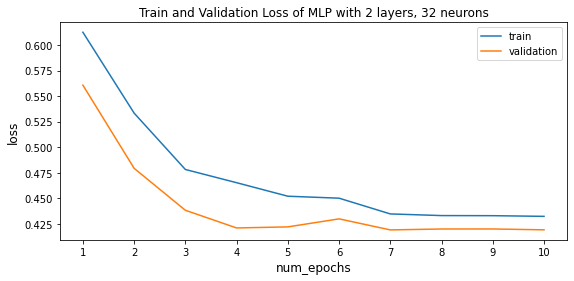

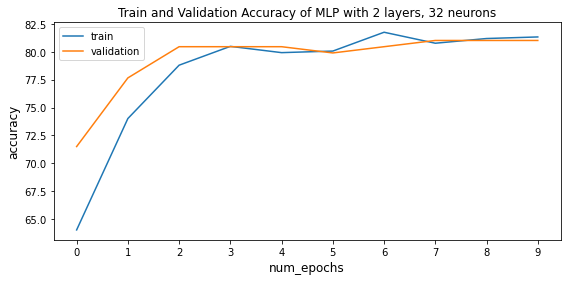

In [14]:
plot_graph(n_epochs,n)

In [15]:
# # Loading model with best validation accuracy
test_model = Net(n)
# test_model.cuda()
test_model.load_state_dict(torch.load('./best_val_model.pth'))
predictions = np.asarray(test_prediction(test_loader, test_model))

pred = predictions.astype('int')
pred[152]=0 # Anomoly with sample 152 causing very negative prediction - TBD.
print("Model test prediction successfull!")

Model test prediction successfull!


In [16]:
## Saving model test prediction to csv for competition submission

# Getting todays date for naming csv output file
today = date.today()

# Creating output as pandas dataframe
output = pd.DataFrame({'PassengerId': testing_data.PassengerId, 'Survived': pred})

# Converting dataframes to csv for competition submission
output.to_csv(f'submission-{today}.csv', index=False)

# CSV saving confirmation
print(f"Model prediction file: submission-{today}.csv successfully saved!")

Model prediction file: submission-2022-03-01.csv successfully saved!
